## UCLA Feature Engineering Project:

### Predict app ratings on Google play store



In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Loading the data
df = pd.read_csv('C:/Users/xtron/Desktop/UCLA Feature Engineering Project/googleplaystore.csv')

In [2]:
%matplotlib inline

In [3]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

# Data Exploration and Cleaning

In [4]:
df.head()
# Executing the above script will display the first five rows of the dataset as shown below

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The dataset has 10,841 records and 13 columns, all of them are object types except the target column (Rating) which is float

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

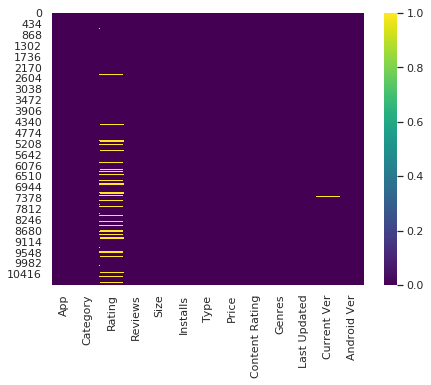

In [6]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

Looks like there are missing values in "Rating", "Type", "Content Rating" and " Android Ver". But most of these missing values in Rating column.

In [7]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

There are two strategies to handle missing data, either removing records with these missing values or replacing missing values with a specific value like (mean, median or mode) value of the column.

In [8]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [9]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [10]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


It's obvious that the first value of this record is missing (App name) and all other values are respectively propagated backward starting from "Category" towards the "Current Ver"; and the last column which is "Android Ver" is left null. It's better to drop the entire recored instead of consider these unreasonable values while cleaning each column!


In [11]:
# Drop this bad column
df = df.drop(i)

In [12]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# Categorical Data Encoding

Many machine learning algorithms can support categorical values without further manipulation but there are many more algorithms that do not. We need to make all data ready for the model, so we will convert categorical variables (variables that stored as text values) into numircal variables.

In [13]:
# App values encoding (help normalize labels such that they contain only values between 0 and n_classes-1)
# I added application name ("App") to the features because I felt like is a keyword rich (in some way shape the key function of the app) 
# and has the most authoritative meta-data (search data) that the store search engine has to go by. 
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [14]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [15]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [16]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [17]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [18]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [19]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

The above line drops the reference column and just keeps only one of the two columns as retaining this extra column does not add any new information for the modeling process, this line is exactly the same as setting drop_first parameter to True.

In [20]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [21]:
# Convert kbytes to Mbytes 
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter

This can be done by selecting all k values from the "Size" column and replace those values by their corresponding M values, and since k indices belong to a list of non-consecutive numbers, a new dataframe (converter) will be created with these k indices to perform the conversion, then the final values will be assigned back to the "Size" column.

In [22]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

# Evaluation Procedure

In [23]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

The above script splits the dataset into 85% train data and 25% test data.

# K-Nearest Neighbors Model

In [25]:
# Look at the 15 closest neighbors
model = KNeighborsRegressor(n_neighbors=15)

In [26]:
# Find the mean accuracy of knn regression using X_test and y_test
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

In [27]:
# Calculate the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 92.22%'

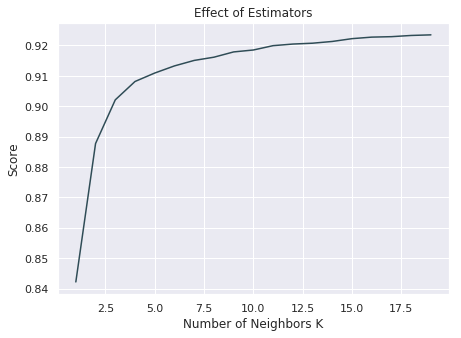

In [28]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

# Random Forest Model

[(10, 0.9307891789898468),
 (20, 0.9337964035147583),
 (30, 0.9361471865014085),
 (40, 0.9368599282717953),
 (50, 0.9372149408108804),
 (60, 0.9372285797754314),
 (70, 0.9368129434404451),
 (80, 0.9379971921652365),
 (90, 0.9382132617681548),
 (100, 0.9376069586457),
 (110, 0.9370750230017678),
 (120, 0.9383974457124791),
 (130, 0.9377523262701132),
 (140, 0.9384702368349193),
 (150, 0.9383696739600448),
 (160, 0.9377126837279367),
 (170, 0.9379187093850607),
 (180, 0.9383997867828282),
 (190, 0.9384356193730613)]

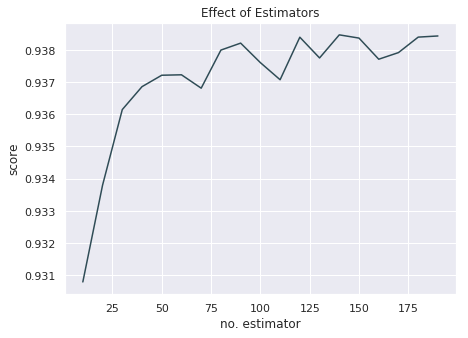

In [29]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [30]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions)

('Mean Absolute Error:', 0.24206214798990117)

In [31]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predictions)

('Mean Squared Error:', 0.16063827580214862)

In [32]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions))

('Root Mean Squared Error:', 0.40079705064053134)